### Recognizing High-redshift Galaxy Mergers with Convolutional Neural Networks using DeepMerge simulated data with an application on real-world data
# Real data

In [1]:
import os
import numpy as np
import time

from astropy.io import fits
from astropy.utils.data import download_file
from astropy.visualization import simple_norm

import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.nn as nn
from sklearn.model_selection import train_test_split
import pandas as pd
import h5py # for manipulating h5 files
from skimage.transform import resize # for resizing the images

*Ema Donev, 2023.*

In this notebook you will find all the information about the real data downloaded from AstroNN how to prepare it for modelling.

## Section 1: Downloading the data

The data is from AstroNN, https://astronn.readthedocs.io/en/latest/galaxy10.html. I am downloading the Galaxy10 DECals dataset, which includes 17736 images of different galaxy types. These images were obtained from the SDSS images from the Galaxy Zoo Data release 2. The images were processed and published so that the general public can classify the galaxy images, since there are so many. After many classified images, it was determined that ~38 classifications were made per image and that the labels are just as trustworthy as if professional scientists classified galaxies. 

The data is a `H5` file, or a `Hierarchical Data Format`. These are used to store massive amounts of data as multidimensional arrays, of which images are an example. Scientific data is typicaly stored in this format, and originally it was selected by NASA as a standard data format in science. 

In [2]:
# defining the filepath to the dataset
filename = '../input/Galaxy10_DECals.h5'

In [3]:
hf = h5py.File(filename, 'r+')
hf.keys() # to find out all the column names in the dataset

<KeysViewHDF5 ['ans', 'dec', 'images', 'pxscale', 'ra', 'redshift']>

After accesing the columns available in the dataset, I extract the images from column `images`, and the labels from column `ans`. I also print their shape to check if the data was loaded accurately.

In [4]:
images_r = hf['images'] # images
print(images_r.shape)
labels_r = hf['ans'] # labels
print(labels_r.shape)

(17736, 256, 256, 3)
(17736,)


## Section 2: viewing the data

Using the same code as in the previous notebook, I showed 3 examples of the images. 

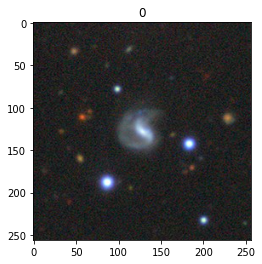

In [5]:
image = images_r[3]
norm = simple_norm(image, 'log', max_percent=99.75)
plt.imshow(image, aspect='equal', norm=norm)
plt.title(labels_r[3])
plt.show()

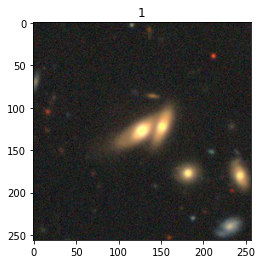

In [16]:
image = images_r[1082]
norm = simple_norm(image, 'log', max_percent=99.75)
plt.imshow(image, aspect='equal', norm=norm)
plt.title(labels_r[1082])
plt.show()

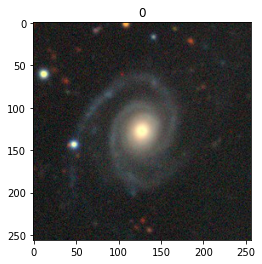

In [17]:
image = images_r[9984]
norm = simple_norm(image, 'log', max_percent=99.75)
plt.imshow(image, aspect='equal', norm=norm)
plt.title(labels_r[9984])
plt.show()

## Section 3: adapting the labels

The labels are designed as such: 
-  Class 0 (1081 images): Disturbed Galaxies
- Class 1 (1853 images): Merging Galaxies
-  Class 2 (2645 images): Round Smooth Galaxies
- Class 3 (2027 images): In-between Round Smooth Galaxies
- Class 4 ( 334 images): Cigar Shaped Smooth Galaxies
- Class 5 (2043 images): Barred Spiral Galaxies
- Class 6 (1829 images): Unbarred Tight Spiral Galaxies
- Class 7 (2628 images): Unbarred Loose Spiral Galaxies
- Class 8 (1423 images): Edge-on Galaxies without Bulge
-  Class 9 (1873 images): Edge-on Galaxies with Bulge

Since the problem is a binary classification, it requires 2 labels, not 10. So, I am going to leave class 1(label 1) as the merger class, and group all the other classes into class 0 (label 0) as the non-merging class.

In [8]:
for i, element in enumerate(labels_r):
    if element != 1:
        labels_r[i] = 0

Now that we only have non-merger and merger labels, we can continue with the data preparation.

## Section 4: resizing the images

These images all have 3 layers, however they are 256x256 pixels, while the simulated images are 75x75 pixels. In order for the model to accept both sets of (simulated and real) images, I have to crop the 256x256 images into 75x75 images. 

In order for me to change the dimensions of every image, it is important to create a new array which is empty which can store every image inside once it is resized.

In [15]:
# creating an empy array to store all of the resized images
resized_images = np.empty((len(images_r), 75, 75, 3))

# resizing the images using scikit-image
for i, image in enumerate(images_r):
    resized_images[i] = resize(image, (75,75), mode='reflect')

KeyboardInterrupt: 

## Section 5: Final preparations for modeling

As with the simuated data in notebook `02_Simulated_data`, we continue the process here once the labels and images are sorted. First, we change the float type to `float32`.

In [ ]:
images_real = resized_images.astype(np.float32)
labels_real = labels_r.astype(np.float32)

Then, same as before, we split the datasets into training, validation and test sets with the `70% : 20% : 10%` division.

In [ ]:
x_train, x_rem, y_train, y_rem = train_test_split(images_real,labels_real, train_size=0.7, random_state=42, shuffle=True) # cutting off training data and the rest goes into the next stage

x_valid, x_test, y_valid, y_test = train_test_split(x_rem,y_rem, test_size=0.34, random_state=42, shuffle=True) # dividing the validation and testing sets

Next we transform the data into `Tensors`.

In [ ]:
x_train, y_train, x_valid, y_valid, x_test, y_test = map(torch.tensor, (x_train, y_train, x_valid, y_valid, x_test, y_test))

Next we organize the data into batches.

In [ ]:
bs = 64
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs)

test_ds = TensorDataset(x_test, y_test)
test_dl = DataLoader(test_ds, batch_size=bs)

## Section 6: The shape of the dataset

Now that the data is ready for modelling, we must consider the shape and how **balanced** the dataset is. We currently have 17736 images and 2 labels: class 0 are non-mergers, while class 1 are galaxy mergers.

The ratio is `15883 : 1853`, or `90% : 10%`, which is a very large imbalance. Considering we have a very large amount of images, data augmentation is an option, however a better option would be to adjust the threshold values later in the models based on the balance of the dataset. In this case, the threshold value would then be 0.1, because the percentage of the positive class is 10% of the entire dataset.

In the next notebook I will introduce the reference architecture and then go through the process of creating my own architecture.